# CISC 6930 Data Mining
## Homework 3 (36 points)
### Yifan Ren

### 1. Read the adult.names file and study the raw. Understanding the domain is a key step in data mining. Write down three issues or hypotheses that you would ideally like to investigate. As one example, you could switch the class variable to “sex” and try to predict that variable from the rest of the variables. You can also consider other things, such as strategies for preprocessing the data to possibly improve predictive performance. In short, come up with three issues/strategies that you might be interesting in following up on (6 points).

    1)It is interesting to switch the class variable to “Marital-status” so that we could predict an individual’s marital status based on other features.

    2) The variable of “workclass” is also a good target class to be predicted using the rest of the variables.

    3)	As the “adult.names” showed, there are 3620 rows of data with missing value showed as ”?” and 6 duplicate or conflicting instances.
        In order to handle preprocessing conveniently and create our own partitions, the original partitions of datasets would be ignored and the two datasets could be combined together.

In [1]:
import pandas as pd
col_names = ["age","workclass","fnlwgt","education","education-num","marital-status","occupation",
            "relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country","income"]
df_1 = pd.read_csv("adult.data",names=col_names,index_col=False)
df_2 = pd.read_csv("adult.test",names=col_names,index_col=False)
df = pd.concat([df_1,df_2],ignore_index=True)

    The examples of merged dataset are showed below

In [2]:
df.tail()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48838,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K.
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.
48841,35,Self-emp-inc,182148,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,60,United-States,>50K.


    Given the description about the feature of "fnlwgt" in "adult.names", the feature is unnecessary for us to make predictions. Hence, it will be removed.

In [3]:
df.drop("fnlwgt",axis=1,inplace=True)

    Beacuse the missing value were showed as ”?”, so we have to convert them to NaN values. However, many values are having space in the cell, so we have to remove them firstly and then convert the "?".

In [4]:
import numpy as np
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
for i in df.columns.values.tolist():
    df[i] = df[i].map(lambda x: np.nan if x=="?"  else x)

In [5]:
#Check the number of missing values and duplicate instances
print("    The number of missing values is {} and".format(df[df.isnull().T.any()].shape[0]),
"of duplicate instances is {}.".format(df[df.duplicated()].shape[0]))

    The number of missing values is 3620 and of duplicate instances is 4487.


    It looks like that the number of missing values was the same as it in our data, but the number of duplicate instances is different. Our result showed there are 29 duplicate instances actually.
    The missing value will be replaced with the mode value of in the column, because all the values of columns with missing value were categorical. 
    As the number of duplicate instances is different from the number was showed in “adult.names”, those duplicate instances will be retained to avoid unpredictable accident.

In [6]:
for col in ["workclass","occupation","native-country"]: df[col].fillna(df[col].mode()[0],inplace=True)

In [7]:
#Let's check the dataset again.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
age               48842 non-null int64
workclass         48842 non-null object
education         48842 non-null object
education-num     48842 non-null int64
marital-status    48842 non-null object
occupation        48842 non-null object
relationship      48842 non-null object
race              48842 non-null object
sex               48842 non-null object
capital-gain      48842 non-null int64
capital-loss      48842 non-null int64
hours-per-week    48842 non-null int64
native-country    48842 non-null object
income            48842 non-null object
dtypes: int64(5), object(9)
memory usage: 5.2+ MB


    Now, all the missing value had been solved, but there are some special characters like dots which will affect our work, so those characters should be removed as well.

In [8]:
for col in df.columns:
    if df[col].dtype != 'int64':
        df[col] = df[col].apply(lambda val: val.replace(".", ""))

## 2. Apply a decision tree classifier using the default parameters to the adult dataset, with the goal of predicting the class variable. If using WEKA, use the J48 classifier and if using Python use one of the decision tree classifiers. You should partition the data so that 2/3 is used for training and 1/3 used for testing. Answer the following questions (6 points):

    In order to use sklearn.tree.DecisionTreeClassifier to bulid a tree classifier well, firstly we need to to conver our categorical variables to continuous variables. The tool of LableEncoder is used here to finish the convertion.

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn_pandas import DataFrameMapper
mapper = DataFrameMapper([('workclass', LabelEncoder()),('education', LabelEncoder()),
                          ('marital-status', LabelEncoder()),('occupation', LabelEncoder()),
                          ('relationship', LabelEncoder()),('race', LabelEncoder()),
                          ('sex', LabelEncoder()),('native-country', LabelEncoder()),('income', LabelEncoder())],
                         df_out=True, default=None)

    And then, we should split our dataset into training set and testing set separately so that 2/3 is used for training and 1/3 used for testing.

In [10]:
from sklearn.model_selection import train_test_split

df_copy = mapper.fit_transform(df.copy())

cols = df_copy.columns.values.tolist()
cols_t = ["income"]
cols.remove(cols_t[0])

train_data,test_data,train_target,test_target = train_test_split(df_copy[cols], df_copy[cols_t], test_size = (1/3))

    Now, we are able to build a DecisionTree classifier, we name the model trained as DTtree. It uses CART as the default   algorithm.

In [11]:
from sklearn.tree import DecisionTreeClassifier
DTtree = DecisionTreeClassifier()
DTtree.fit(train_data.values, train_target.values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

    Yes. We had bulit a model already. Let's test them and answer the questions for assignment.
    
### a. What is the accuracy of the classifier on the test data?
    0.8172102450709416
    It is got from the following function.

In [12]:
DTtree.score(test_data, test_target)

0.8172102450709416

### b. How many leaves are there in the generated tree?
    5916
    It is got from the following function.

In [13]:
DTtree.get_n_leaves()

5916

### c. Copy and paste the confusion matrix
    Although we can easily get the confusion matrix from sklearn, it could be presented as a narray rather than a diagram. It is not a nice method to observe by us. So we need to use the matplotlib library to get a directly visible chart.

In [14]:
from sklearn.metrics import confusion_matrix
#Get the confusion matrix as narray
y_pred = DTtree.predict(test_data)
y_true = test_target
cm=confusion_matrix(y_true, y_pred)

    Because there is not a function that could be imported directly,we need to bulid our own function to dram a diagram for confusion matrix. The following function is altered based on an open source function in scikit-learn official Github.

In [15]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if (i==0 and j==0) or (i==0 and j==1):
            plt.text(j, i+0.2, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     verticalalignment='center',
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i-0.2, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     verticalalignment='center',
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Confusion matrix, without normalization
[[10889  1445]
 [ 1531  2416]]


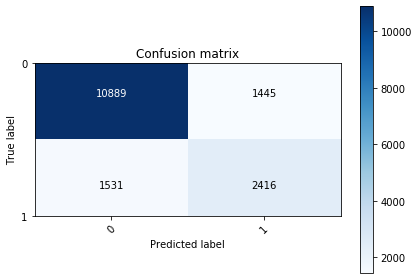

In [16]:
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],
                      title='Confusion matrix')

## 3. Rerun the same experiment (i.e., build and evaluate a decision tree), but this time use 10-fold cross validation. Report the accuracy of the experiment over the 10 runs. (6 points)

    Let's start our 10-fold cross validation via the cross_val_score function from scikit-learn. And the accuracy of the    prediction is showed 10 times below.

In [17]:
from sklearn.model_selection import cross_val_score
DTtree2 = DecisionTreeClassifier()
cross_val_score(DTtree2, train_data.values,train_target.values, cv=10)

array([0.82161498, 0.81019656, 0.81633907, 0.81511057, 0.8227887 ,
       0.81910319, 0.81296069, 0.81910319, 0.82585995, 0.81726044])

In [18]:
DTtree2.fit(train_data.values, train_target.values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

### Report the accuracy of the experiment over the 10 runs.
    0.8177016153798907
    
    It is got from the following function.

In [19]:
DTtree2.score(test_data.values, test_target.values)

0.8177016153798907

## 4. Repeat question 2 (i.e., use a 2/3, 1/3 split), but this time modify one of the default decision tree parameters. Describe the change that you made and then answer the three questions (a, b, c) from Question 2. Comment on any differences. (6 points)

    Next, we decide to limit the minimum number of samples required to be at a leaf node, so that actually the number of leaf nodes will be reduced. We ask the minimum numberof samples should be never less than 10, and build the classifier again.

In [20]:
DTtree3 = DecisionTreeClassifier(min_samples_split=10)
DTtree3.fit(train_data.values, train_target.values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

### a. What is the accuracy of the classifier on the test data?
    0.8334868865548799
    
    It is got from the following function.
    
    Wow, it looks better than the original model with default parameters, which got the accuracy of 0.8169031386278484. We  suppose that the limit may lead to avoid overfiting by so-called pruning in some ways, so that the performance become   better on testing data. 

In [21]:
DTtree3.score(test_data, test_target)

0.8334868865548799

### b. How many leaves are there in the generated tree?
    3184
    
    It is got from the following function.
    
    Actually, compared to the leaves' number of the original model, the leaves here have been reduced for our limit strategy for pruning the tree.

In [22]:
DTtree3.get_n_leaves()

3184

    Finally, let's get the confusion matrix. It shows than the new one get better recall rate and precision rate as well than the original model.

### c. Copy and paste the confusion matrix

Confusion matrix, without normalization
[[11196  1138]
 [ 1573  2374]]


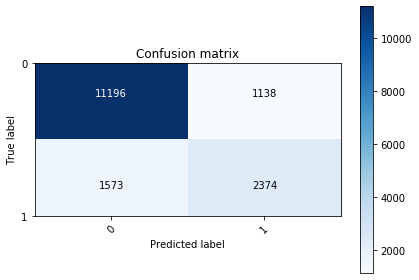

In [23]:
y_pred3 = DTtree3.predict(test_data)
y_true = test_target
cm3=confusion_matrix(y_true, y_pred3)
plot_confusion_matrix(cm3, classes=[0,1],
                      title='Confusion matrix')

## 5. Repeat question 2, but this time execute the Random Forest algorithm rather than a regular decision tree algorithm. Specify how many trees are generated in the Random Forest. Report the answers to parts a and c, from question 2. Then compare the results to the results when using the decision tree algorithm. (6 points)

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
rf = RandomForestClassifier()

In [26]:
rf.fit(train_data.values, train_target.values)

D:\Anacoda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anacoda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### a. What is the accuracy of the classifier on the test data?
    0.844419875928997
    
    It is got from the following function.
    
    The accuracy of random forest classifier is better than decision tree classifier apparently. The original decision tree had accuracy of 0.8172102450709416, even if we use 10-fold cross validation or altering the default parameter, the decision tree model had accuracy of 0.8177016153798907 and 0.8334868865548799, lower than random forest.

In [27]:
rf.score(test_data, test_target)

0.844419875928997

### c. Copy and paste the confusion matrix

Confusion matrix, without normalization
[[11393   941]
 [ 1592  2355]]


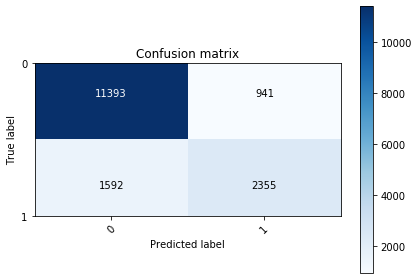

In [28]:
y_pred4 = rf.predict(test_data)
y_true = test_target
cm4=confusion_matrix(y_true, y_pred4)
plot_confusion_matrix(cm4, classes=[0,1],
                      title='Confusion matrix')

    However, according to the confusion matrix, we observed that the random forest model has higher recall rate of class 0, which is income less than 50k, but the recall rate of class 1 perform similar with decision tree.

## 6. Change the class variable to “sex” and build a decision tree classifier to predict sex. (In Weka you can do this by using the “Classify” tab to select J48, as usual, and then go to the left column to the button under the “More Option …” and manually change the class/target variable from “class” to “(Nom) sex)”. Repeat question 2 and answer parts a, b, and c. Then answer the following additional questions: (6 points):

    Firstly, we should revise our target variable and split the set into training set and testing set again.

In [29]:
cols2 = df_copy.columns.values.tolist()
cols_t2 = ["sex"]
cols2.remove(cols_t2[0])

train_data2,test_data2,train_target2,test_target2 = train_test_split(df_copy[cols2], df_copy[cols_t2], test_size = (1/3))

    Now, we can build our new decision tree model based on our revised dataset.

In [30]:
DTtree4 = DecisionTreeClassifier()
DTtree4.fit(train_data2.values, train_target2.values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

### a. What is the accuracy of the classifier on the test data?
    The accuracy of the model looks good. It achieves 0.8058473066764941.

In [31]:
DTtree4.score(test_data2,test_target2)

0.8058473066764941

### b. How many leaves are there in the generated tree?
    5691

In [32]:
DTtree4.get_n_leaves()

5691

### c. Copy and paste the confusion matrix

Confusion matrix, without normalization
[[3869 1568]
 [1593 9251]]


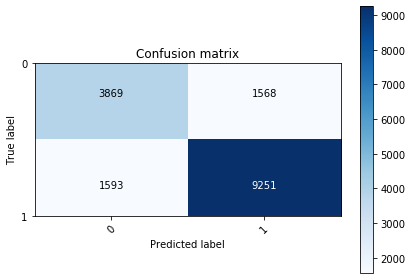

In [33]:
y_pred5 = DTtree4.predict(test_data2)
y_true2 = test_target2
cm5=confusion_matrix(y_true2, y_pred5)
plot_confusion_matrix(cm5, classes=[0,1],
                      title='Confusion matrix')

### a) Based on the results in the confusion matrix, specify the number of females and males in the test set as counts (whole numbers) and as percentages. (1 point)

    N(female) = 4975+366 = 5437
    N(male) = 7457+3483 = 10844
    P(female) = 5437/(5437+10844) = 0.3339 = 33.39%
    P(male) = 10844/(5437+10844) = 0.6661 = 66.61%

### b) If you had to build a simple classifier to always guess the most common sex, what would the accuracy of the classifier be? (1 point)

    Accuracy = 10844/(10844+5437+0+0) = 0.6661 = 66.61%

### c) Carefully examine the induced decision tree, and the attributes involved, and state why the high accuracy results are almost completely meaningless. What is the problem? (2 points)

    Firstly, let's focus on the precision and recall rate. Actually, the rates of class 0, female, are greatly lower than those of class 1, male. Meanwhile, the number of female instances is also significantly lower than the number of male instances, it may lead to data imbalance.

In [34]:
from sklearn.metrics import classification_report

print(classification_report(y_true2, y_pred5))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71      5437
           1       0.86      0.85      0.85     10844

    accuracy                           0.81     16281
   macro avg       0.78      0.78      0.78     16281
weighted avg       0.81      0.81      0.81     16281



    Next, we will review the original dataset and these attributes involved in building model.

In [35]:
df.groupby(["relationship","sex"]).count()

age  workclass  education  education-num  \
relationship   sex                                                  
Husband        Female      1          1          1              1   
               Male    19715      19715      19715          19715   
Not-in-family  Female   5870       5870       5870           5870   
               Male     6713       6713       6713           6713   
Other-relative Female    689        689        689            689   
               Male      817        817        817            817   
Own-child      Female   3376       3376       3376           3376   
               Male     4205       4205       4205           4205   
Unmarried      Female   3928       3928       3928           3928   
               Male     1197       1197       1197           1197   
Wife           Female   2328       2328       2328           2328   
               Male        3          3          3              3   

                       marital-status  occupation   race  capital-gain  \
relationship   sex                                                       
Husband        Female               1           1      1             1   
               Male             19715       19715  19715         19715   
Not-in-family  Female            5870        5870   5870          5870   
               Male              6713        6713   6713          6713   
Other-relative Female             689         689    689           689   
               Male               817         817    817           817   
Own-child      Female            3376        3376   3376          3376   
               Male              4205        4205   4205          4205   
Unmarried      Female            3928        3928   3928          3928   
               Male              1197        1197   1197          1197   
Wife           Female            2328        2328   2328          2328   
               Male                 3           3      3             3   

                       capital-loss  hours-per-week  native-country  income  
relationship   sex                                                           
Husband        Female             1               1               1       1  
               Male           19715           19715           19715   19715  
Not-in-family  Female          5870            5870            5870    5870  
               Male            6713            6713            6713    6713  
Other-relative Female           689             689             689     689  
               Male             817             817             817     817  
Own-child      Female          3376            3376            3376    3376  
               Male            4205            4205            4205    4205  
Unmarried      Female          3928            3928            3928    3928  
               Male            1197            1197            1197    1197  
Wife           Female          2328            2328            2328    2328  
               Male               3               3               3       3

    Oh, we find that there is an interesting attribute named "relationship". Generally in our society, the husband in a family is usually a male, and the wife in a family is usually a female. The distribution of them in our dataset present the case as well. Hence, based on the attribute "relationship", which is significantly related to the target class itself, the model can easily predict the class of the most instances.
    
    If we remove the "relationship" attribute and build the model again, we can review the performance to see whether it is supported.

In [36]:
train_data3 = train_data2.drop('relationship',axis=1)
test_data3 = test_data2.drop('relationship',axis=1)
train_target3=train_target2
test_target3=test_target2

In [37]:
DTtree5 = DecisionTreeClassifier()
DTtree5.fit(train_data3.values, train_target3.values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [38]:
DTtree5.score(test_data3,test_target3)

0.7367483569805294

    Obviously, the accuracy of the model cannot perform good as well.
    
    What about other index, like recall rate and precision rate?

Confusion matrix, without normalization
[[3438 1999]
 [2287 8557]]


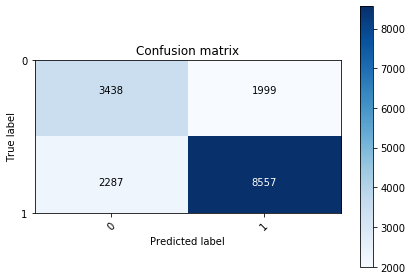

In [39]:
y_pred6 = DTtree5.predict(test_data3)
y_true3 = test_target3
cm6=confusion_matrix(y_true3, y_pred6)
plot_confusion_matrix(cm6, classes=[0,1],
                      title='Confusion matrix')

In [40]:
print(classification_report(y_true3, y_pred6))

              precision    recall  f1-score   support

           0       0.60      0.63      0.62      5437
           1       0.81      0.79      0.80     10844

    accuracy                           0.74     16281
   macro avg       0.71      0.71      0.71     16281
weighted avg       0.74      0.74      0.74     16281



    It shows that the precision and recall rates of class 0 are very bad. Combined with the data imbalance, we cannot use the model to predict the target variable of instances well.
    
    Given the above discussion, the high accuracy results of the original model are almost completely meaningless.